In [1]:
import numpy as np #Import relevant packages
import pandas as pd
import math
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import glob
import csv
import matplotlib.pyplot as plt

In [2]:
def unpack_data(filepath): #Returns a dictionary where each item is a df containing one run. One dict per generation.
    all_files = glob.glob(filepath + "/*.csv")
    name_list = []
    datadict = {}
    for f in all_files:
        name_list.append(f[77:-4])
    for i,n in enumerate(name_list):
        datadict[n] = pd.read_csv(all_files[i], header=0)
    for k, v in datadict.items():
        v.drop(columns=["Unnamed: 0", "volume", "spread", "10_MA", "50_MA"], inplace=True)
    return datadict

def format_data(datadict, window): #Turn dictionaries of data into features and samples lists
    x_data = []
    y_data = []
    for k, v in datadict.items():
        for i in range(len(v)):
            if i >= window:
                y_data.append(v.iloc[i]["trading_price"])
                xi = v.iloc[i-window:i].to_numpy()
                x_data.append(xi)
    x_data = np.array(x_data)
    y_data = np.array(y_data)
    y_data = np.reshape(y_data, (y_data.shape[0], 1))
    return x_data, y_data

def normalise_data(xarray, yarray): #Take the natural log and then normalise prices
    yarray_log = np.log(yarray)
    xarray_log = np.log(xarray)
    xsc = StandardScaler()
    instances, timesteps, features = xarray_log.shape
    xarray_log = np.reshape(xarray_log, (-1, features))
    xarray_norm = xsc.fit_transform(xarray_log)
    xarray_norm = np.reshape(xarray_norm, (instances, timesteps, features))
    ysc = StandardScaler().fit(yarray_log)
    yarray_norm = ysc.transform(yarray_log)
    return xarray_norm, yarray_norm, xsc, ysc

def split_data(xarray, yarray, trainratio): #Split the data into training and test sets
    train_len = int(len(xarray)*trainratio)
    test_len = len(xarray) - train_len
    x_train, y_train, x_test, y_test = xarray[:train_len], yarray[:train_len], xarray[train_len:], yarray[train_len:]
    return x_train, y_train, x_test, y_test

In [3]:
gen5 = unpack_data("/Users/karangarg/Documents/Year 3 Modules/EC331/Code/rae_repo/gen5_sims/data")

In [28]:
X6, y6 = format_data(gen5, 20)
print(X6.shape)
print(y6.shape)

(31162, 20, 2)
(31162, 1)


In [29]:
X6_train, y6_train, X6_test, y6_test = split_data(X6, y6, 0.8)

In [30]:
X6_train, y6_train, X6scale, y6scale = normalise_data(X6_train, y6_train)
X6_test, y6_test, _, _ = normalise_data(X6_test, y6_test)
X6_train = X6_train[~np.isnan(X6_train).any(axis=3)]
y6_train = y6_train[~np.isnan(y6_train).any(axis=1)]
X6_test = X6_test[~np.isnan(X6_test).any(axis=3)]
y6_test = y6_test[~np.isnan(y6_test).any(axis=1)]

/Users/karangarg/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in log
/Users/karangarg/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in log


AxisError: axis 3 is out of bounds for array of dimension 3

In [ ]:
print(X6_train.shape)

In [19]:
print(X6scale.mean_)
print(X6scale.var_)
print(y6scale.mean_)
print(y6scale.var_)
print(X6_train)
print(y6_train)

[4.65090666 4.79639306]
[0.1224202  0.01614435]
[4.65225912]
[0.13224917]
[[-0.13071821 -1.50497593]
 [-0.15050728 -1.49710959]
 [-0.15425104 -1.47199002]
 ...
 [ 0.12996923 -0.97910665]
 [ 0.14350353 -0.9717485 ]
 [ 0.1189907  -0.96439723]]
[[-0.21835055]
 [-0.22489062]
 [-0.24546504]
 ...
 [ 0.13434885]
 [ 0.11076452]
 [ 0.12884721]]


In [9]:
lstm6=keras.Sequential() #Set up the architecture of the model

lstm6.add(layers.LSTM(units=16, input_shape=(X6_train.shape[1], X6_train.shape[2])))
lstm6.add(layers.Dropout(0.2))

lstm6.add(layers.Dense(units=1))

In [10]:
print(lstm6.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 16)                1216      
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 1,233
Trainable params: 1,233
Non-trainable params: 0
_________________________________________________________________
None


In [11]:
lstm6.compile(optimizer='nadam', loss='mean_squared_error') #Compile and train the model

history6 = lstm6.fit(X6_train, y6_train, epochs = 10, batch_size = 32, validation_split=0.2, shuffle=False)

Train on 19943 samples, validate on 4986 samples
Epoch 1/10
19943/19943 [==============================] - 39s 2ms/sample - loss: nan - val_loss: nan
Epoch 2/10
19943/19943 [==============================] - 27s 1ms/sample - loss: nan - val_loss: nan
Epoch 3/10
19943/19943 [==============================] - 28s 1ms/sample - loss: nan - val_loss: nan
Epoch 4/10
19943/19943 [==============================] - 30s 1ms/sample - loss: nan - val_loss: nan
Epoch 5/10
19943/19943 [==============================] - 23s 1ms/sample - loss: nan - val_loss: nan
Epoch 6/10
19943/19943 [==============================] - 23s 1ms/sample - loss: nan - val_loss: nan
Epoch 7/10
19943/19943 [==============================] - 25s 1ms/sample - loss: nan - val_loss: nan
Epoch 8/10
19943/19943 [==============================] - 24s 1ms/sample - loss: nan - val_loss: nan
Epoch 9/10
19943/19943 [==============================] - 25s 1ms/sample - loss: nan - val_loss: nan
Epoch 10/10
19943/19943 [=================

In [12]:
lstm6.save("/Users/karangarg/Documents/Year 3 Modules/EC331/Code/rae_repo/lstms/lstm6")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /Users/karangarg/Documents/Year 3 Modules/EC331/Code/rae_repo/lstms/lstm6/assets


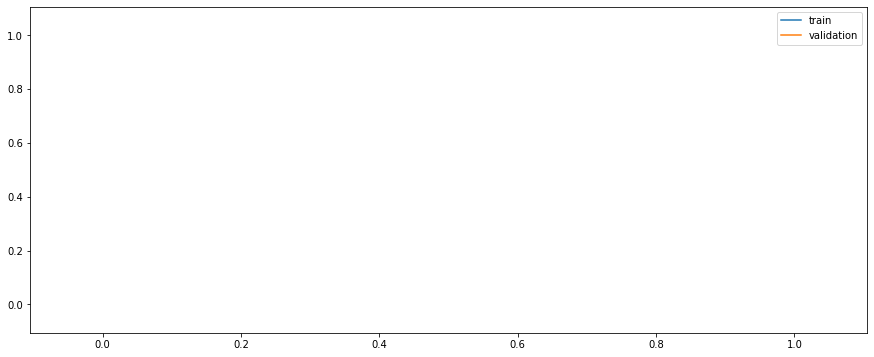

In [13]:
plt.figure(figsize=(15,6))
plt.plot(history6.history["loss"], label="train")
plt.plot(history6.history["val_loss"], label="validation")
plt.legend()

In [14]:
y6_pred = lstm6.predict(X6_test)
y6_train_inv = y6scale.inverse_transform(y6_train.reshape(1, -1))
y6_test_inv = y6scale.inverse_transform(y6_test.reshape(1, -1))
y6_pred_inv  = y6scale.inverse_transform(y6_pred)

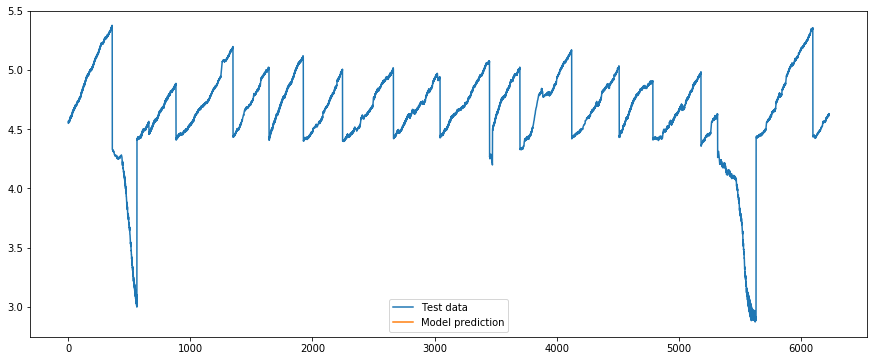

In [15]:
plt.figure(figsize=(15,6))
plt.plot(y6_test_inv.flatten(), label="Test data")
plt.plot(y6_pred_inv.flatten(), label="Model prediction")
plt.legend()